In [1]:
import torch
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
# 版本查询
torch.__version__

'2.0.1+cpu'

# 数据准备

In [3]:
# 数据归一化处理（-1，1）
transform = transforms.Compose([
    transforms.ToTensor(),  #0-1 
    transforms.Normalize(0.5,0.5) # 均值和方差都为
])

In [4]:
train_ds = torchvision.datasets.MNIST('data',
                                     train=True,
                                     transform=transform,
                                     download=True)

In [5]:
dataloader = torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)

In [6]:
# 查看dataloader的方法
imgs,_ = next(iter(dataloader))

In [7]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [8]:
imgs.size(0)

64

原始图像：


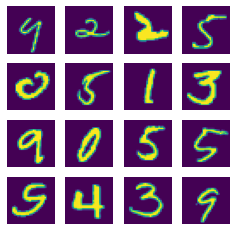

In [37]:
print('原始图像：')
fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((imgs[i][0]+1)/2)
    plt.axis('off')

# 定义生成器

In [9]:
# 输入是长度为100的噪声（正态分布随机数）
# 输出为（1，28，28）大小的图片

# linear 1 :100--256
# linear 2 : 256--512
# linear 3 : 512--28*28
# reshape: 28*28----1,28,28

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
            # 生成器的最后一层的激活函数用Tanh 规范到-1到1之间
            nn.Tanh()
        )
    def forward(self,x):   # x表示噪声输入
        img = self.main(x)
        img = img.view(-1,28,28,1)
        return img

# 定义判别器

In [11]:
# 输入为一张（1，28，28）图片 输出是一个二分类的概率值，输出使用sigmoid激活 0-1
# BCELoss计算交叉熵损失
# LeakyReLU f(x): x>0,输出x，x<0，输出a*x a表示一个很小的斜率值 比如0.1
# 判别器中一般推荐使用LeakyReLu，

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            # 生成器的最后一层的激活函数用Tanh 规范到-1到1之间
            nn.Sigmoid()
        )
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.main(x)
        return x

# 初始化模型，优化器及损失函数

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# 实例化
gen = Generator().to(device)
dis = Discriminator().to(device)

In [15]:
gen

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [16]:
d_optim = torch.optim.Adam(dis.parameters(),lr=0.0001)
g_optim = torch.optim.Adam(gen.parameters(),lr=0.0001)

In [17]:
loss_fn = torch.nn.BCELoss()

# 绘图函数

In [27]:
def gen_img_plot(model,test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize = (4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i]+1)/2) # 将预测的输出结果转换到0-1之间，绘图
        plt.axis('off')
    plt.show()

In [25]:
test_input = torch.randn(16,100,device=device)

# GAN的训练

In [20]:
D_loss = []   # 存放loss
G_loss = []

Epoch: 0


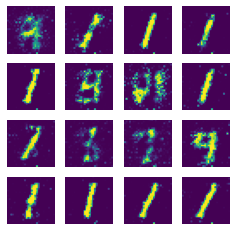

Epoch: 1


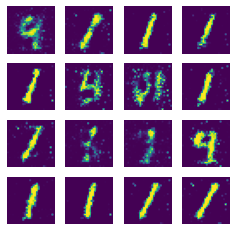

Epoch: 2


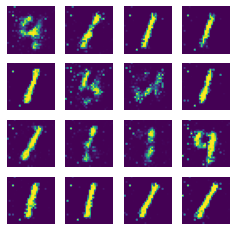

Epoch: 3


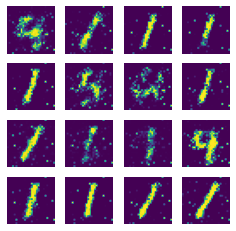

Epoch: 4


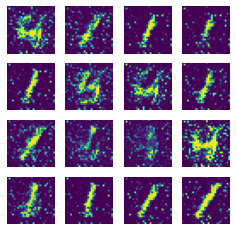

Epoch: 5


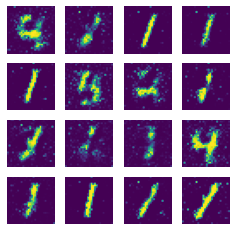

Epoch: 6


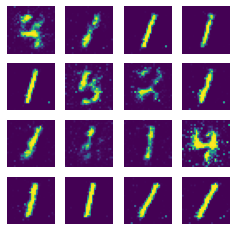

Epoch: 7


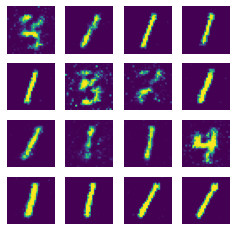

Epoch: 8


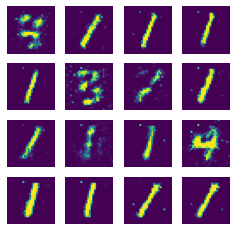

Epoch: 9


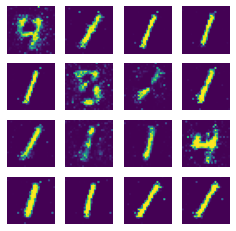

Epoch: 10


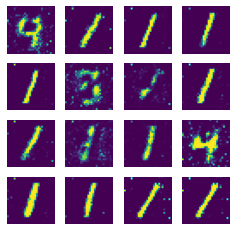

Epoch: 11


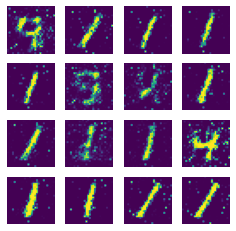

Epoch: 12


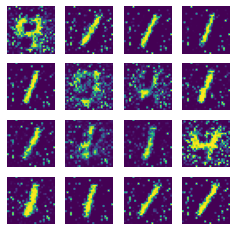

Epoch: 13


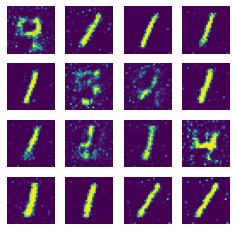

Epoch: 14


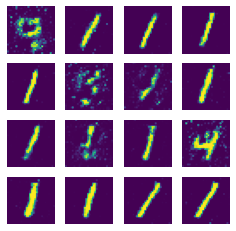

Epoch: 15


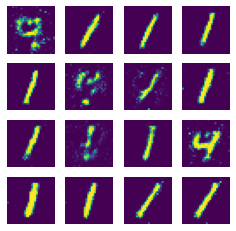

Epoch: 16


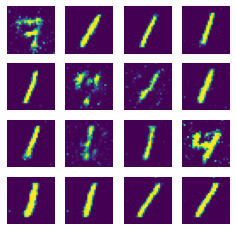

Epoch: 17


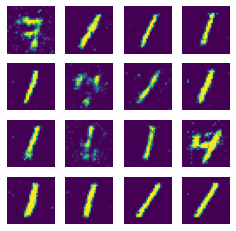

Epoch: 18


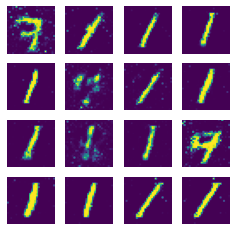

Epoch: 19


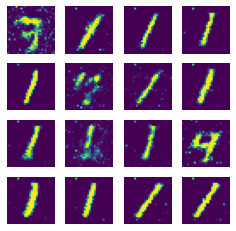

Epoch: 20


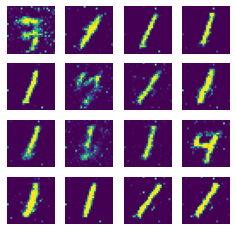

Epoch: 21


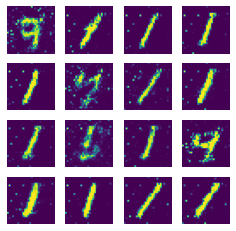

Epoch: 22


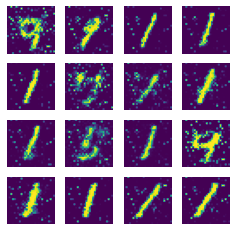

Epoch: 23


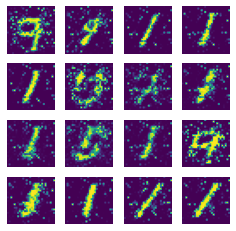

Epoch: 24


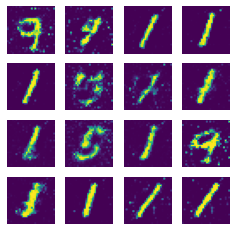

Epoch: 25


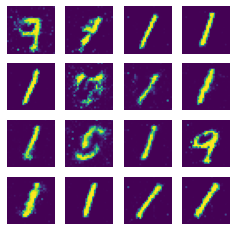

Epoch: 26


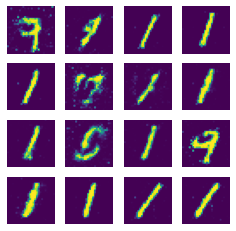

Epoch: 27


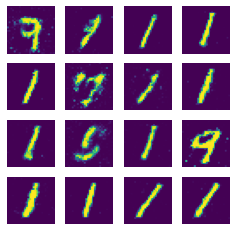

Epoch: 28


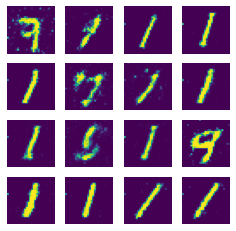

Epoch: 29


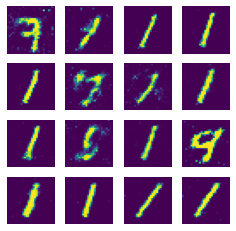

Epoch: 30


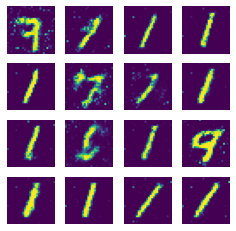

Epoch: 31


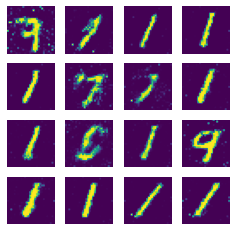

Epoch: 32


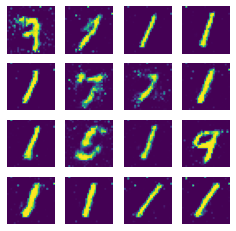

Epoch: 33


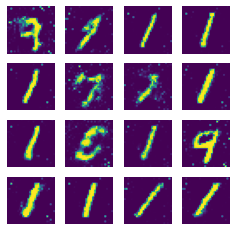

Epoch: 34


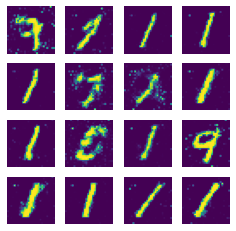

Epoch: 35


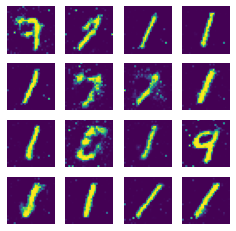

Epoch: 36


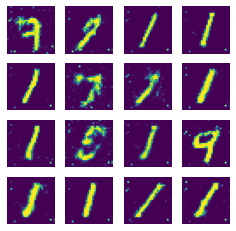

Epoch: 37


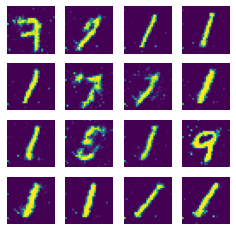

Epoch: 38


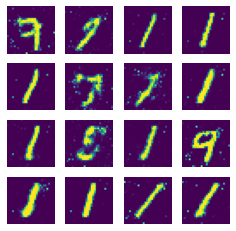

Epoch: 39


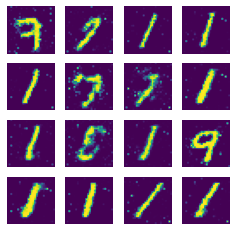

Epoch: 40


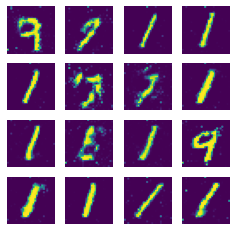

Epoch: 41


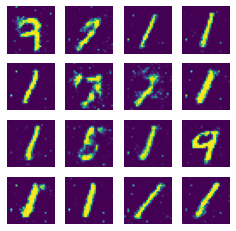

Epoch: 42


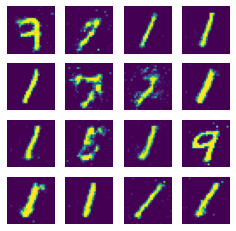

Epoch: 43


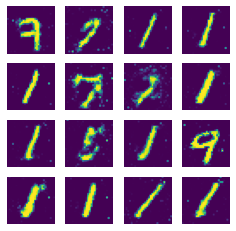

Epoch: 44


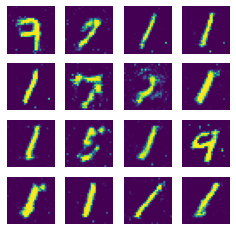

Epoch: 45


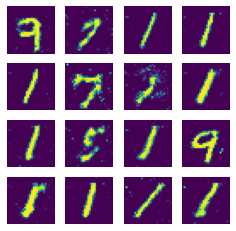

Epoch: 46


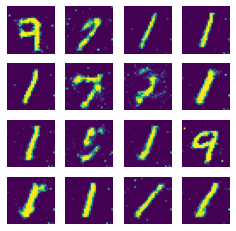

Epoch: 47


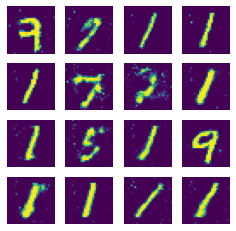

Epoch: 48


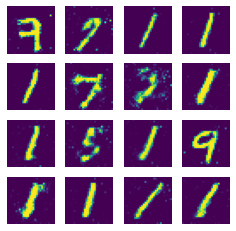

Epoch: 49


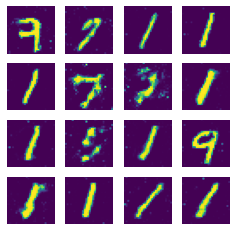

In [36]:
# 循环  
for epoch in range(50):
    d_epoch_loss = 0
    g_epoch_loss = 0
    # 批次数
    count = len(dataloader)
    for step,(img,_) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size,100,device=device) # 创建同样大小的噪声数据
        # 对真实数据进行判别计算损失，梯度
        # 先是优化器
        d_optim.zero_grad()
        real_output = dis(img) #对判别器输入真实图片，得出真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output))     # 判别器在真实图像上的损失 （希望判别器识别真图为真
        d_real_loss.backward()
        # 对生成图片上进行判别，计算  (此处是为了 --优化判别器)
        gen_img = gen(random_noise)
        fake_output = dis(gen_img.detach()) 
        d_fake_loss = loss_fn(fake_output,
                             torch.zeros_like(fake_output))      # 生成图像上的损失 （希望判别器识别假图为假
        d_fake_loss.backward()
        
        d_loss = d_real_loss + d_fake_loss 
        d_optim.step()
        # 生成器
        g_optim.zero_grad()
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output,
                         torch.ones_like(fake_output))      # 希望生成器的图片被判定为真
        g_loss.backward()
        g_optim.step()
        
        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch:', epoch)
        gen_img_plot(model=gen, test_input=test_input)